In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
from sklearn.metrics import euclidean_distances
from sklearn.cluster import SpectralClustering

In [3]:
np.random.seed(1)

In [4]:
num_obs = 100
num_features = 10
count_cluster1 = int(0.75 * num_obs)
count_cluster2 = num_obs - count_cluster1
x = np.vstack([
    np.random.normal(0, 10, (count_cluster1, num_features)),
    np.random.normal(10, 10, (count_cluster2, num_features)),
])
expected = np.asarray(np.arange(num_obs) > count_cluster1, dtype='int')

permute = np.random.permutation(num_obs)

x = x[permute, :]
expected = expected[permute]

d = euclidean_distances(x, squared = False)
d_sq = euclidean_distances(x, squared = True)

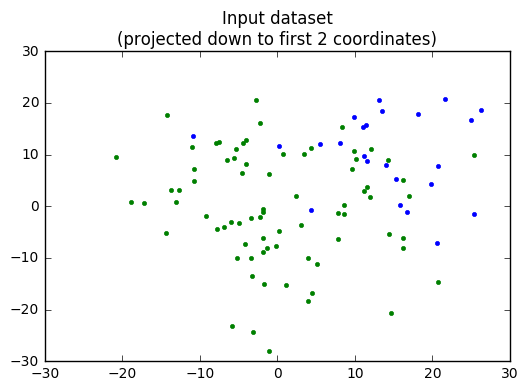

In [5]:
plt.figure()
mask1 = expected == 1
plt.plot(x[mask1,0], x[mask1,1], 'b.')
plt.plot(x[~mask1,0], x[~mask1,1], 'g.')
plt.title("Input dataset\n(projected down to first 2 coordinates)")
None

In [6]:
from timeit import default_timer

def start_timer():
    start = default_timer()
    return lambda: default_timer() - start

In [7]:
def partition(sim, seed):
    sim = np.copy(sim)
    res = SpectralClustering(
        n_clusters=2,
        affinity='precomputed',
        random_state=seed,
        assign_labels='discretize',
    ).fit(sim)
    labels = res.labels_
    labels0 = labels[labels == 0]
    fraction = len(labels0) / float(len(labels))

    err_rates = []
    incorrect = evaluate_clusters(labels, expected)["incorrect"]
    #print incorrect, type(incorrect)
    err_rates.append(len(incorrect) / float(len(labels)))
    
    return labels, fraction, min(err_rates)

In [8]:
def evaluate_clusters(partition, expected):
    pred_act_00 = (partition == 0) & (expected == 0)
    pred_act_01 = (partition == 0) & (expected == 1)
    pred_act_10 = (partition == 1) & (expected == 0)
    pred_act_11 = (partition == 1) & (expected == 1)

    # Handle the case where we merely need to swap the cluster labels
    if np.count_nonzero(pred_act_00) + np.count_nonzero(pred_act_11) \
            < np.count_nonzero(pred_act_01) + np.count_nonzero(pred_act_10):
        pred_act_11, pred_act_10 = pred_act_10, pred_act_11
        pred_act_00, pred_act_01 = pred_act_01, pred_act_00

    incorrect = np.array(sorted(
        list(np.flatnonzero(pred_act_01)) +
        list(np.flatnonzero(pred_act_10))
    ))
        
    return {
        "correct_0": np.flatnonzero(pred_act_00),
        "correct_1": np.flatnonzero(pred_act_11),
        "incorrect": incorrect,
    }

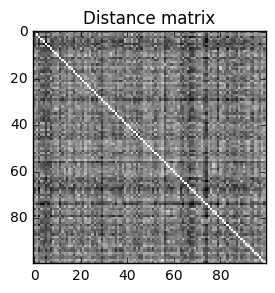

In [9]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(3, 3, forward=True)
ax.imshow(d, interpolation = 'none', cmap='gray_r', vmin=0)
ax.set_title("Distance matrix")
None

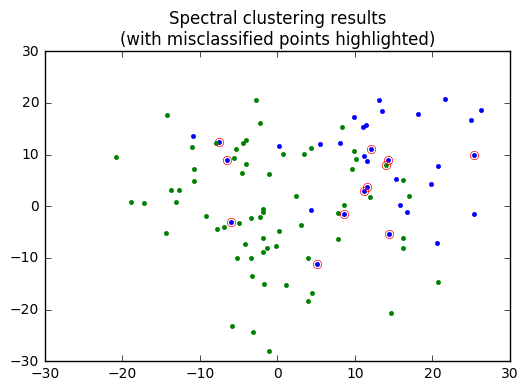

In [10]:
sigma = 100.0
example_partition = partition(np.exp(-d_sq / (2. * sigma ** 2)), seed = 1)[0]
mask_ex = example_partition == 1

wrong = evaluate_clusters(example_partition, expected)["incorrect"]

plt.figure()
plt.plot(x[mask_ex,0], x[mask_ex,1], 'b.')
plt.plot(x[~mask_ex,0], x[~mask_ex,1], 'g.')
plt.plot(x[wrong,0], x[wrong,1], 'o', mec = 'r', mfc = 'none')
plt.title("Spectral clustering results\n(with misclassified points highlighted)")
None

/usr/local/lib/python2.7/site-packages/sklearn/manifold/spectral_embedding_.py:217: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


sigma = 0.0, best timing = 0.00220417976379, err_rate range = (0.37, 0.5), exceptions = 0
sigma = 0.001, best timing = 0.00226211547852, err_rate range = (0.38, 0.5), exceptions = 0
sigma = 0.01, best timing = 0.0022120475769, err_rate range = (0.36, 0.5), exceptions = 0
sigma = 0.1, best timing = 0.00228905677795, err_rate range = (0.38, 0.5), exceptions = 0
sigma = 1.0, best timing = 0.234000921249, err_rate range = (0.27, 0.5), exceptions = 13
sigma = 10.0, best timing = 0.00655794143677, err_rate range = (0.12, 0.12), exceptions = 0
sigma = 30.0, best timing = 0.00348615646362, err_rate range = (0.09, 0.09), exceptions = 0
sigma = 50.0, best timing = 0.00338912010193, err_rate range = (0.09, 0.12), exceptions = 0
sigma = 100.0, best timing = 0.00338816642761, err_rate range = (0.11, 0.12), exceptions = 0
sigma = 1000.0, best timing = 0.00327706336975, err_rate range = (0.11, 0.12), exceptions = 0
sigma = 10000.0, best timing = 0.00304388999939, err_rate range = (0.11, 0.12), except

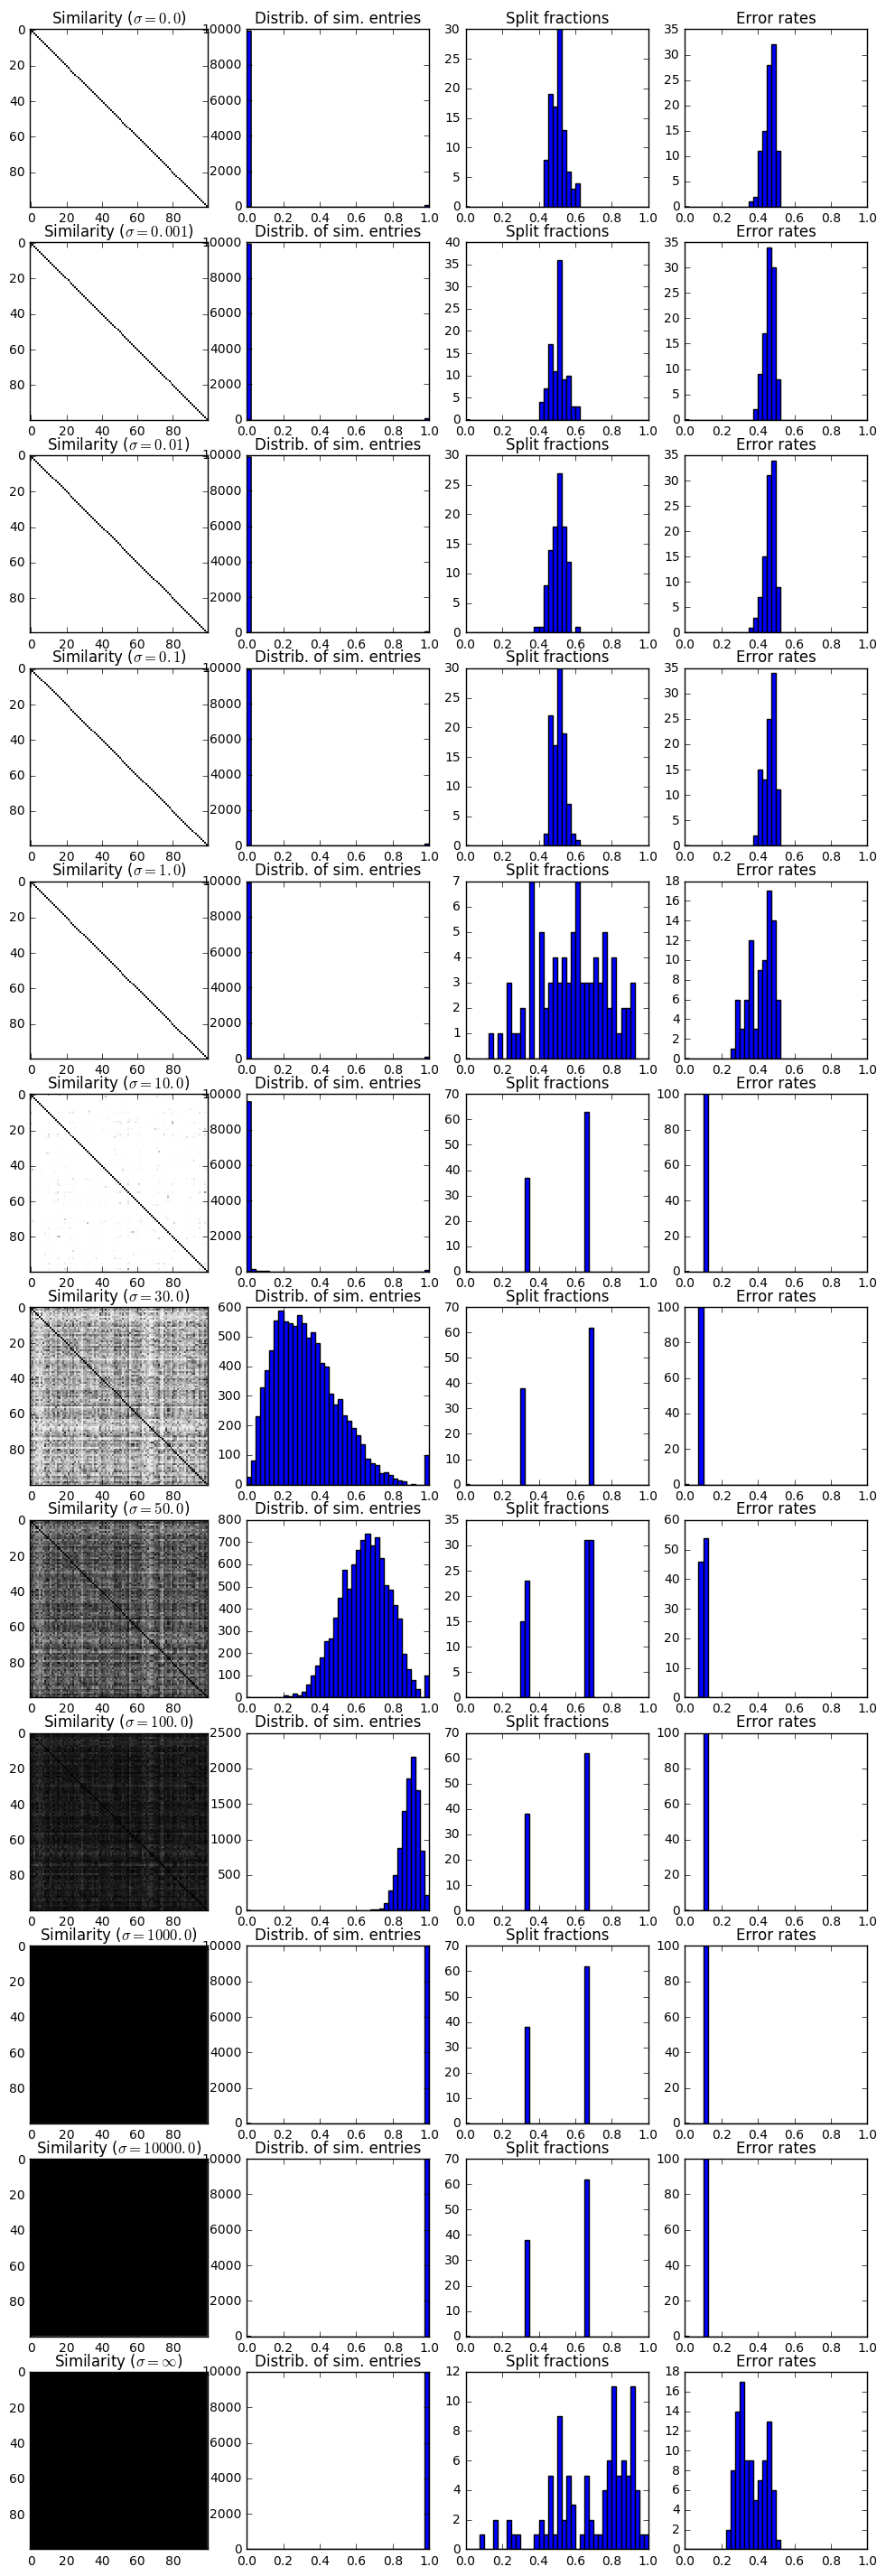

In [11]:
sigmas = [0., 1e-3, 1e-2, 1e-1, 1., 10., 30., 50., 100., 1000., 10000., np.inf]
num_plots_x = 4
fig, ax = plt.subplots(len(sigmas), num_plots_x)
fig.set_size_inches(3 * num_plots_x, 3 * len(sigmas), forward=True)

for i, sigma in enumerate(sigmas):
    if not np.isfinite(sigma):
        sim = np.ones_like(d_sq)
        sigma_str = r'\infty'
    elif sigma == 0.0:
        sim = np.eye(num_obs)
        sigma_str = str(sigma)
    else:
        sim = np.exp(-d_sq/(2. * sigma ** 2))
        sigma_str = str(sigma)
    
    ax[i, 0].imshow(sim, interpolation = 'none', cmap='gray_r', vmin=0, vmax=1)
    ax[i, 0].set_title("Similarity ($\sigma = {}$)".format(sigma_str))
    
    ax[i, 1].hist(sim.flatten(), bins=40, range=(0,1))
    ax[i, 1].set_xlim(0, 1)
    ax[i, 1].set_title("Distrib. of sim. entries")
    
    n_trials = 100
    
    fractions = []
    times = []
    err_rates = []
    num_exceptions = 0
    for n in xrange(n_trials):
        np.random.seed(n)
        t = start_timer()
        try:
            p, f, err_rate = partition(sim, seed=n)
            fractions.append(f)
            err_rates.append(err_rate)
        except (AssertionError) as e:
            if "Not equal to tolerance" not in e.args[0]:
                raise
            num_exceptions += 1
        except (np.linalg.LinAlgError,):
            num_exceptions += 1
        times.append(t())
    
    if len(fractions) > 0:
        ax[i, 2].hist(fractions, bins=40, range=(0,1))
        ax[i, 2].set_xlim(0, 1)
        ax[i, 2].set_title("Split fractions")
        
        ax[i, 3].hist(err_rates, bins=40, range=(0,1))
        ax[i, 3].set_xlim(0, 1)
        ax[i, 3].set_title("Error rates")
    
    print "sigma = {}, best timing = {}, err_rate range = {}, exceptions = {}" \
        .format(sigma, min(times), (min(err_rates), max(err_rates)), num_exceptions)

In [12]:
fig.savefig("grid_spectral_clustering.pdf")